In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image


In [3]:
# Define paths
dataset_path = '/content/drive/MyDrive/face_recog_1/Image1'
train_path = '/content/drive/MyDrive/face_recog_1/Image1/train/'
test_path = '/content/drive/MyDrive/face_recog_1/Image1/test/'

In [4]:
# Create directories if they don't exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

In [8]:
# Split dataset into training and testing sets
for person in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person)
    images = os.listdir(person_path)
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

    os.makedirs(os.path.join(train_path, person), exist_ok=True)
    os.makedirs(os.path.join(test_path, person), exist_ok=True)

    for img in train_images:
        shutil.copy(os.path.join(person_path, img), os.path.join(train_path, person, img))

    for img in test_images:
        shutil.copy(os.path.join(person_path, img), os.path.join(test_path, person, img))


In [9]:

# re-size all the images to this
IMAGE_SIZE = [224, 224]

# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [10]:

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [12]:
  from glob import glob

  # useful for getting number of classes
folders = glob('/content/drive/MyDrive/face_recog_1/Image1/train/*')

In [13]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [14]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [15]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [17]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [18]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [19]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/face_recog_1/Image1/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 235 images belonging to 4 classes.


In [20]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/face_recog_1/Image1/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 60 images belonging to 4 classes.


In [21]:
import os
from PIL import Image



def verify_images(directory):
  count=0

  for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Verify that it is, in fact, an image
                img.close()
            except (IOError, SyntaxError) as e:
                print(f"Bad file: {file_path}")
                count=count+1
  print(count)
# Check training and test sets
verify_images('/content/drive/MyDrive/face_recog_1/Image1/train')
verify_images('/content/drive/MyDrive/face_recog_1/Image1/test')


0
0


In [33]:


      r = model.fit(
            training_set,
            validation_data=test_set,
            epochs=5,
            steps_per_epoch=len(training_set),
            validation_steps=len(test_set)
)


Epoch 1/5
8/8 [==============================] - 170s 21s/step - loss: 0.0487 - accuracy: 1.0000 - val_loss: 0.0611 - val_accuracy: 0.9833
Epoch 2/5
8/8 [==============================] - 174s 22s/step - loss: 0.0468 - accuracy: 0.9957 - val_loss: 0.0469 - val_accuracy: 1.0000
Epoch 3/5
8/8 [==============================] - 172s 22s/step - loss: 0.0384 - accuracy: 1.0000 - val_loss: 0.0497 - val_accuracy: 1.0000
Epoch 4/5
8/8 [==============================] - 169s 21s/step - loss: 0.0298 - accuracy: 1.0000 - val_loss: 0.0402 - val_accuracy: 1.0000
Epoch 5/5
8/8 [==============================] - 174s 22s/step - loss: 0.0237 - accuracy: 1.0000 - val_loss: 0.0408 - val_accuracy: 0.9833


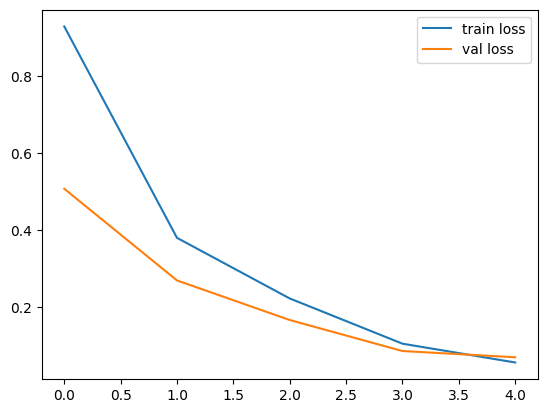

<Figure size 640x480 with 0 Axes>

In [24]:
# loss

import matplotlib.pyplot as plt

plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

In [35]:
import tensorflow as tf

from keras.models import load_model

model.save('facefeatures_new1_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
